In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.utils.data as Data

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img_dir = './data/jamo/'
img_data = dsets.ImageFolder(img_dir, transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
]))

print(img_data.classes)
print(img_data.class_to_idx)

['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄸ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅉ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', 'ㅏ', 'ㅐ', 'ㅑ', 'ㅒ', 'ㅓ', 'ㅔ', 'ㅕ', 'ㅖ', 'ㅗ', 'ㅘ', 'ㅙ', 'ㅛ', 'ㅜ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅠ', 'ㅡ', 'ㅢ', 'ㅣ']
{'ㄱ': 0, 'ㄲ': 1, 'ㄴ': 2, 'ㄷ': 3, 'ㄸ': 4, 'ㄹ': 5, 'ㅁ': 6, 'ㅂ': 7, 'ㅃ': 8, 'ㅅ': 9, 'ㅆ': 10, 'ㅇ': 11, 'ㅈ': 12, 'ㅉ': 13, 'ㅊ': 14, 'ㅋ': 15, 'ㅌ': 16, 'ㅍ': 17, 'ㅎ': 18, 'ㅏ': 19, 'ㅐ': 20, 'ㅑ': 21, 'ㅒ': 22, 'ㅓ': 23, 'ㅔ': 24, 'ㅕ': 25, 'ㅖ': 26, 'ㅗ': 27, 'ㅘ': 28, 'ㅙ': 29, 'ㅛ': 30, 'ㅜ': 31, 'ㅝ': 32, 'ㅞ': 33, 'ㅟ': 34, 'ㅠ': 35, 'ㅡ': 36, 'ㅢ': 37, 'ㅣ': 38}


In [3]:
batch_size = 100

In [4]:
def train_test_split(data, train_ratio, batch_size, stratify) :
    
    length = len(data)
    
    cut = int(len(data)*train_ratio)
    train_indices = np.random.shuffle(np.random.permutation(np.arange(length))[:cut])
    test_indices = np.random.shuffle(np.random.permutation(np.arange(length))[cut:])
        
    if stratify :
        
        count = [0]*len(img_data.classes)
        for _, label in img_data :
            count[label] += 1

        weight = []    
        for i, (_, label) in enumerate(img_data) :
            weight.append(1/ count[label])
        weight = np.array(weight)
        
        train_indices = np.random.choice(length, cut, p=weight/sum(weight), replace=False)
        test_indices = np.array(list(set(range(length)) - set(train_indices)))
        
    train_loader = Data.DataLoader(data, batch_size=batch_size, shuffle=False, sampler = torch.utils.data.SubsetRandomSampler(train_indices), drop_last = True)
    test_loader = Data.DataLoader(data, batch_size=batch_size, shuffle=False, sampler = torch.utils.data.SubsetRandomSampler(test_indices), drop_last = True)

    return train_loader, test_loader, len(train_indices), len(test_indices)

In [5]:
train_loader, test_loader, train_num, test_num = train_test_split(img_data, 0.8, batch_size, True)

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

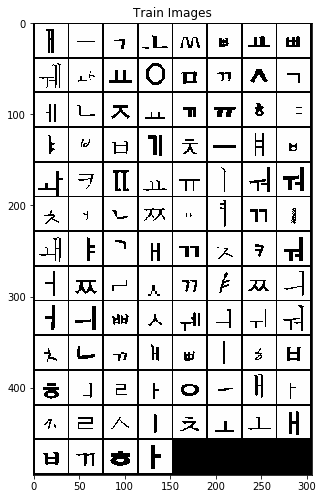

In [7]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), 'Train Images')

In [8]:
images.shape, labels[0:5]

(torch.Size([100, 1, 36, 36]), tensor([20, 36,  0, 27, 10]))

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, 5), # 16 * 32 * 32
            nn.ReLU(),
            nn.Conv2d(16, 32, 5), # 32 * 28 * 28
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # 32 * 14 * 14
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(32 * 14 * 14, 39)
        )
            
    def forward(self, x):
            out = self.conv_layer(x)
            out = out.view(batch_size, -1)
            out = self.fc_layer(out)
            
            return out

In [26]:
model = CNN()

In [27]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [28]:
num_epochs = 5

In [29]:
for epoch in range(num_epochs):
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images
        Y = batch_labels
        
        pre = model(X)
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i + 1) % batch_size == 0:
            print('Epoch: [%d/%d], Iter: [%d/%d], cost: %.4f' % (epoch + 1, num_epochs,
                                                             i + 1, train_num // batch_size, 
                                                             cost.item()))

Epoch: [1/5], Iter: [100/224], cost: 0.9070
Epoch: [1/5], Iter: [200/224], cost: 0.5213
Epoch: [2/5], Iter: [100/224], cost: 0.1894
Epoch: [2/5], Iter: [200/224], cost: 0.4736
Epoch: [3/5], Iter: [100/224], cost: 0.0941
Epoch: [3/5], Iter: [200/224], cost: 0.1448
Epoch: [4/5], Iter: [100/224], cost: 0.1654
Epoch: [4/5], Iter: [200/224], cost: 0.0551
Epoch: [5/5], Iter: [100/224], cost: 0.0762
Epoch: [5/5], Iter: [200/224], cost: 0.2087


In [30]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (labels == predicted).sum()
    
print('Accuracy: %f %%' % (100 * float(correct) / total))

Accuracy: 94.232143 %
